In [19]:
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt
import pycaret.regression as pyr
from sklearn.metrics import mean_absolute_error


In [20]:
df = pd.read_csv("consumption_temp.csv")
df['time'] = pd.to_datetime(df['time'])

df.describe()

,consumption,temperature
count,49494.000000,49494.000000
mean,3.509242,6.554019
std,3.096356,7.630308
min,0.000000,-17.299999
25%,1.263256,1.000000
50%,2.376530,6.800000
75%,5.189000,12.100000
max,18.045011,30.500000


In [21]:
import pandas as pd
import numpy as np

df['hour'] = df['time'].dt.hour
df['day_of_week'] = df['time'].dt.dayofweek
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
df['month'] = df['time'].dt.month

df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)

In [22]:

lags = [24, 25, 26, 48, 49, 50, 72]
delay = 120

for lag in lags:
    df[f'load_t-{lag}h'] = df.groupby('location')['consumption'].shift(lag+delay)
    df[f'avg_load_t-{lag}h'] = df['consumption'].shift(lag+delay).expanding().mean()
    df[f'std_load_t-{lag}h'] = df['consumption'].shift(lag+delay).expanding().std() 
    df[f'temperature_t-{lag}h'] = df.groupby('location')['temperature'].shift(lag)
    

df.reset_index(inplace=True)

df.dropna(inplace=True)

In [23]:

df['original_location'] = df['location']
df = pd.get_dummies(df, columns=['location'])

In [24]:
last_date = df['time'].max().date()
test_start_date = last_date - timedelta(days=29)

df_0_10 = df[df['hour'] < 10].copy()
df_11_24 = df[df['hour'] >= 10].copy()

from sklearn.model_selection import train_test_split

def split_train_test_randomly(df):
    df['time'] = pd.to_datetime(df['time']) 
    
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
    
    return train_df, test_df


df_0_10 = df[df['hour'] < 10].copy()
df_11_24 = df[df['hour'] >= 10].copy()

train_0_10, test_0_10 = split_train_test_randomly(df_0_10)
train_11_24, test_11_24 = split_train_test_randomly(df_11_24)


In [25]:
train, test = split_train_test_randomly(df)
excluded_features_11_24 = ['time', 
                           'temperature', 
                           'original_location',
                           'load_t-24h', 
                           'consumption_t-24h', 
                           'std_load_t-24h',
                           'avg_load_t-24h',
                           'load_t-25h',
                           'consumption_t-25h',
                           'std_load_t-25h', 
                           'avg_load_t-25h',
                           'load_t-26h',
                           'consumption_t-26h',
                           'std_load_t-26h',
                           'avg_load_t-26h'
                           ]
pyr.setup(data=train, target='consumption', ignore_features=excluded_features_11_24, fold_strategy = 'timeseries', session_id=42, data_split_shuffle=False, fold_shuffle=False)
model = pyr.compare_models()

,Description,Value
0,Session id,42
1,Target,consumption
2,Target type,Regression
3,Original data shape,"(38673, 42)"
4,Transformed data shape,"(38673, 30)"
5,Transformed train set shape,"(27071, 30)"
6,Transformed test set shape,"(11602, 30)"
7,Ignore features,15
8,Numeric features,29
9,Preprocess,True


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,20:11:40
Status,. . . . . . . . . . . . . . . . . .,Loading Estimator
Estimator,. . . . . . . . . . . . . . . . . .,Linear Regression


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.1239,0.0524,0.2227,0.9947,0.0390,0.0428,1.4450
lightgbm,Light Gradient Boosting Machine,0.1630,0.0725,0.2669,0.9927,0.0504,0.0590,1.1140
rf,Random Forest Regressor,0.1539,0.0764,0.2714,0.9923,0.0475,0.0527,3.5120
gbr,Gradient Boosting Regressor,0.2311,0.1421,0.3762,0.9856,0.0686,0.0802,1.6540
dt,Decision Tree Regressor,0.2069,0.1579,0.3916,0.9840,0.0678,0.0707,0.1020
knn,K Neighbors Regressor,0.3279,0.2595,0.5014,0.9737,0.1185,0.1410,0.0760
lr,Linear Regression,0.3662,0.3023,0.5494,0.9693,0.1242,0.1530,0.4160
ada,AdaBoost Regressor,0.4578,0.3582,0.5982,0.9636,0.1736,0.2656,0.5250
br,Bayesian Ridge,0.3662,0.3869,0.6213,0.9607,0.1104,0.1297,0.1900
ridge,Ridge Regression,0.3667,0.3867,0.6211,0.9607,0.1106,0.1300,0.0310


In [7]:

excluded_features = ['time', 'temperature', 'original_location']
excluded_features_11_24 = ['time', 
                           'temperature', 
                           'original_location',
                           'load_t-24h', 
                           'consumption_t-24h', 
                           'std_load_t-24h',
                           'avg_load_t-24h',
                           'load_t-25h',
                           'consumption_t-25h',
                           'std_load_t-25h', 
                           'avg_load_t-25h',
                           'load_t-26h',
                           'consumption_t-26h',
                           'std_load_t-26h',
                           'avg_load_t-26h'
                           ]

pyr.setup(data=train_0_10, target='consumption', ignore_features=excluded_features, fold_strategy = 'timeseries', session_id=42, data_split_shuffle=False, fold_shuffle=False)
best_model_0_10 = pyr.create_model('et')
predictions_0_10 = pyr.predict_model(best_model_0_10, data=test_0_10)







,Description,Value
0,Session id,42
1,Target,consumption
2,Target type,Regression
3,Original data shape,"(16112, 42)"
4,Transformed data shape,"(16112, 39)"
5,Transformed train set shape,"(11278, 39)"
6,Transformed test set shape,"(4834, 39)"
7,Ignore features,3
8,Numeric features,38
9,Preprocess,True


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,13:22:14
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Extra Trees Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.2064,0.1564,0.3955,0.9826,0.0642,0.0679
1,0.1682,0.1064,0.3262,0.9887,0.0541,0.0595
2,0.1488,0.0877,0.2961,0.9905,0.0467,0.0532
3,0.1252,0.0476,0.2181,0.9944,0.0410,0.0478
4,0.1205,0.0537,0.2316,0.9935,0.0402,0.0459
5,0.1152,0.0432,0.2078,0.9951,0.0372,0.0409
6,0.1186,0.0495,0.2224,0.9950,0.0367,0.0404
7,0.1065,0.0406,0.2016,0.9956,0.0352,0.0377
8,0.1034,0.0406,0.2016,0.9960,0.0336,0.0366


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0867,0.0268,0.1639,0.9968,0.0298,0.0327


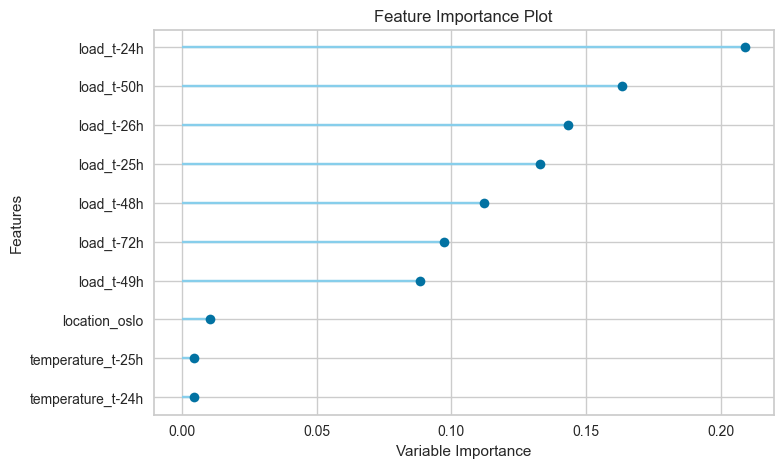

In [8]:
pyr.plot_model(best_model_0_10, plot='feature')

In [9]:
pyr.setup(data=train_11_24, target='consumption', ignore_features=excluded_features_11_24, fold_strategy = 'timeseries', session_id=42, data_split_shuffle=False, fold_shuffle=False)
#best_model_11_24 = pyr.compare_models(sort='mae')
best_model_11_24 =pyr.create_model('et')
predictions_11_24 = pyr.predict_model(best_model_11_24, data=test_11_24)



,Description,Value
0,Session id,42
1,Target,consumption
2,Target type,Regression
3,Original data shape,"(22561, 42)"
4,Transformed data shape,"(22561, 30)"
5,Transformed train set shape,"(15792, 30)"
6,Transformed test set shape,"(6769, 30)"
7,Ignore features,15
8,Numeric features,29
9,Preprocess,True


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,13:22:55
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Extra Trees Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.1961,0.1137,0.3372,0.9893,0.0569,0.0636
1,0.1693,0.1033,0.3215,0.9895,0.0501,0.0530
2,0.1596,0.0833,0.2886,0.9915,0.0461,0.0491
3,0.1402,0.0687,0.2620,0.9931,0.0417,0.0444
4,0.1261,0.0561,0.2370,0.9942,0.0418,0.0410
5,0.1215,0.0467,0.2161,0.9954,0.0375,0.0412
6,0.1106,0.0402,0.2004,0.9963,0.0324,0.0355
7,0.1011,0.0286,0.1692,0.9973,0.0322,0.0349
8,0.0941,0.0286,0.1691,0.9971,0.0304,0.0325


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0910,0.0270,0.1644,0.9973,0.0286,0.0308


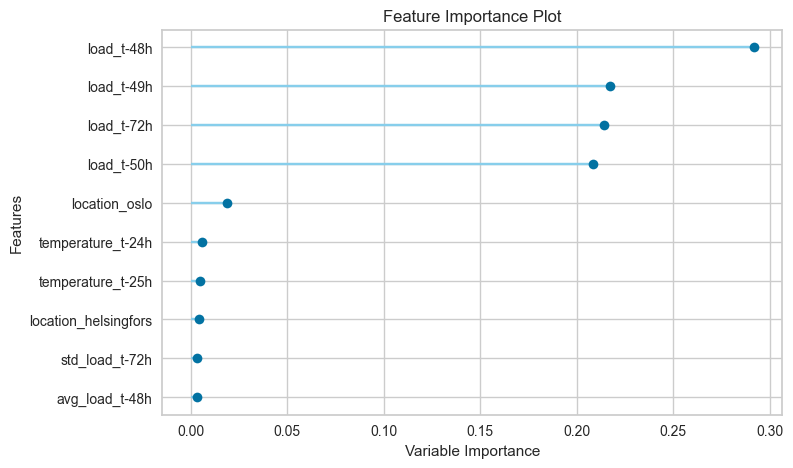

In [11]:
pyr.plot_model(best_model_11_24, plot='feature')

In [12]:
combined_predictions = pd.concat([predictions_0_10, predictions_11_24]).sort_values(by='time')

In [13]:
mae_0_10 = mean_absolute_error(predictions_0_10['prediction_label'], predictions_0_10['consumption'])
mae_11_24 = mean_absolute_error(predictions_11_24['prediction_label'], predictions_11_24['consumption'])

mae_0_24 = mean_absolute_error(combined_predictions['prediction_label'], combined_predictions['consumption'])

print(f'MAE for 0-10: {mae_0_10}')
print(f'MAE for 11-24: {mae_11_24}')
print(f'MAE for 0-24: {mae_0_24}')

MAE for 0-10: 0.08673148040531173
MAE for 11-24: 0.09103350027558271
MAE for 0-24: 0.08924132569315933


In [16]:
import plotly.graph_objects as go

locations = combined_predictions['original_location'].unique()

for location in locations:
    subset_df = combined_predictions[combined_predictions['original_location'] == location]
    
    time = subset_df['time']
    true_values = subset_df['consumption']
    predicted_values = subset_df['prediction_label']
    errors = true_values - predicted_values
    #std_devs = true_values.expanding().std()
    std_devs = true_values.std()
    z_scores = errors / std_devs

    fig = go.Figure()

    # Add traces for true values, predicted values, and z-scores
    fig.add_trace(go.Scatter(x=time, y=true_values, mode='lines', name='True Values'))
    fig.add_trace(go.Scatter(x=time, y=predicted_values, mode='lines', name='Predicted Values'))
    fig.add_trace(go.Scatter(x=time, y=z_scores, mode='lines', name='Z-Scores of Errors', line=dict(dash='dot')))

    # Update layout for better visualization
    fig.update_layout(
        title=f'Predicted and True Values over Time for {location}',
        xaxis_title='Time',
        yaxis_title='Values',
        xaxis=dict(
            rangeselector=dict(
                buttons=list([
                    dict(count=7, label="1w", step="day", stepmode="backward"),
                    dict(count=1, label="1m", step="month", stepmode="backward"),
                    dict(count=6, label="6m", step="month", stepmode="backward"),
                    dict(step="all")
                ])
            ),
            type="date"
        ),
        showlegend=True
    )

    fig.show()





In [18]:
import plotly.graph_objects as go

locations = combined_predictions['original_location'].unique()

for location in locations:
    subset_df = combined_predictions[combined_predictions['original_location'] == location]
    
    time = subset_df['time']
    true_values = subset_df['consumption']
    predicted_values = subset_df['prediction_label']
    errors = true_values - predicted_values
    absolute_percentage_errors = (np.abs(true_values - predicted_values) / true_values) * 100

    print(location,absolute_percentage_errors.mean())

    fig = go.Figure()

    # Add traces for true values, predicted values, and absolute percentage errors
    fig.add_trace(go.Scatter(x=time, y=true_values, mode='lines', name='True Values'))
    fig.add_trace(go.Scatter(x=time, y=predicted_values, mode='lines', name='Predicted Values'))
    fig.add_trace(go.Scatter(x=time, y=absolute_percentage_errors, mode='lines', name='Absolute Percentage Errors', line=dict(dash='dot')))

    # Update layout for better visualization
    fig.update_layout(
        title=f'Predicted and True Values over Time for {location}',
        xaxis_title='Time',
        yaxis_title='Values',
        xaxis=dict(
            rangeselector=dict(
                buttons=list([
                    dict(count=7, label="1w", step="day", stepmode="backward"),
                    dict(count=1, label="1m", step="month", stepmode="backward"),
                    dict(count=6, label="6m", step="month", stepmode="backward"),
                    dict(step="all")
                ])
            ),
            type="date"
        ),
        showlegend=True
    )

    fig.show()



tromsø 3.1863217076886365


oslo 3.2741514145724677


bergen 3.8931714100215014


stavanger 3.4590888844947467


trondheim 3.8371543335764073


helsingfors 0.6342824137524377
